### Importing Dataset and required packages



In [1]:
import os
import numpy as np
import pandas as pd
import pyodbc

# Import CSV
data = pd.read_csv ('german_credit_data_.csv')   
data.drop(data.columns[0], inplace=True, axis=1)
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,67,male,2,own,NaN,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,NaN,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


Removing unneccesory white spaces and capital letters from columns name


In [71]:
data.columns = [x.lower().replace(" ","_") for x in data.columns]
data.columns



Index(['age', 'sex', 'job', 'housing', 'saving_accounts', 'checking_account',
       'credit_amount', 'duration', 'purpose'],
      dtype='object')

In [72]:
data.shape

(1000, 9)

In [73]:
data.dtypes

age                  int64
sex                 object
job                  int64
housing             object
saving_accounts     object
checking_account    object
credit_amount        int64
duration             int64
purpose             object
dtype: object

In [74]:
replacements = {
    'object':'varchar',
    'int64':'bigint'
}
replacements

{'object': 'varchar', 'int64': 'bigint'}

In [75]:
col_str = ", ".join("{} {}".format(n, d)  for (n, d) in zip(data.columns,data.dtypes.replace(replacements)))
col_str

'age bigint, sex varchar, job bigint, housing varchar, saving_accounts varchar, checking_account varchar, credit_amount bigint, duration bigint, purpose varchar'

## Setting MSSQL Server Connection 


In [76]:
pyodbc.drivers()

['SQL Server',
 'Microsoft Access dBASE Driver (*.dbf, *.ndx, *.mdx)',
 'SQL Server Native Client 11.0',
 'SQL Server Native Client RDA 11.0',
 'ODBC Driver 17 for SQL Server',
 'Microsoft Access Driver (*.mdb, *.accdb)',
 'Microsoft Excel Driver (*.xls, *.xlsx, *.xlsm, *.xlsb)',
 'Microsoft Access Text Driver (*.txt, *.csv)',
 'PostgreSQL ANSI(x64)',
 'PostgreSQL Unicode(x64)',
 'Amazon Redshift (x64)']

In [82]:
conn = pyodbc.connect(
Trusted_Connection= 'Yes',
    Driver = ('ODBC Driver 17 for SQL Server'),
    Server = 'MSI',
    Database = 'Db_4'
)

cursor = conn.cursor()


In [83]:
data = data.where(pd.notnull(data), None)

In [85]:

cursor.execute("CREATE TABLE german_credit_data(age bigint, sex nvarchar(50), 
               job bigint, housing nvarchar(50), saving_accounts nvarchar(50), 
               checking_account nvarchar(50),credit_amount bigint, duration bigint, 
               purpose nvarchar(255))")



In [86]:
for row in data.itertuples():
    cursor.execute('''
                INSERT INTO Db_4.dbo.german_credit_data(age, sex, job, housing, saving_accounts, checking_account, credit_amount, duration, purpose)
                VALUES (?,?,?,?,?,?,?,?,?)
                ''',
                row.age, 
                row.sex,
                row.job,
                row.housing,
                row.saving_accounts,
                row.checking_account,
                row.credit_amount,
                row.duration,
                row.purpose
                )
conn.commit()

In [68]:
cursor.execute("select * from german_credit_data")

### fetching Data from Warehouse

In [87]:
data_f = pd.read_sql("SELECT  * FROM german_credit_data", conn)

In [88]:
data_f.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose
0,67,male,2,own,None,little,1169,6,radio/TV
1,22,female,2,own,little,moderate,5951,48,radio/TV
2,49,male,1,own,little,None,2096,12,education
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car


In [89]:
data_f.shape

(1000, 9)

### Exploratory Analysis


In [90]:
print("Missing values in each column:\n{}".format(data_f.isnull().sum()))


Missing values in each column:
age                   0
sex                   0
job                   0
housing               0
saving_accounts     183
checking_account    394
credit_amount         0
duration              0
purpose               0
dtype: int64


In [91]:
print("Unique values in each categorical column:")
for col in data_f.select_dtypes(include=[object]):
    print(col,":", data_f[col].unique())

Unique values in each categorical column:
sex : ['male' 'female']
housing : ['own' 'free' 'rent']
saving_accounts : [None 'little' 'quite rich' 'rich' 'moderate']
checking_account : ['little' 'moderate' None 'rich']
purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


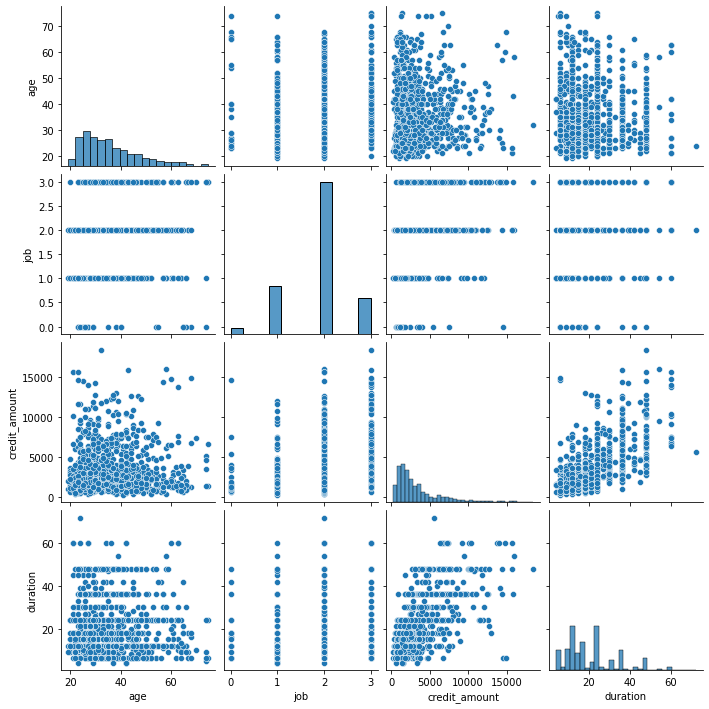

In [92]:
import seaborn as sns
sns.pairplot(data_f)

### Correletion matrix

<AxesSubplot:>

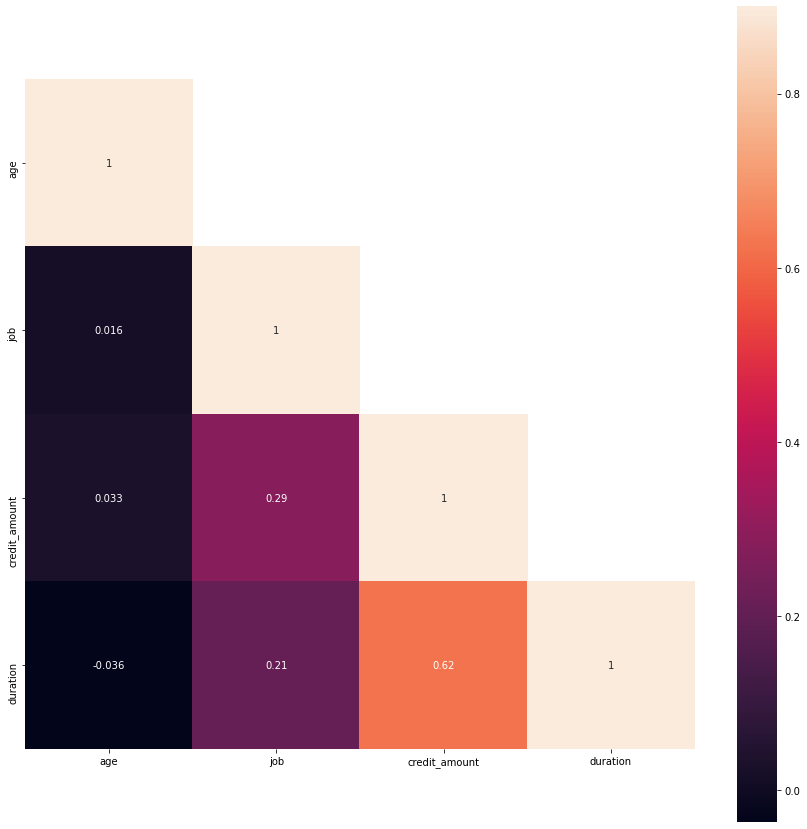

In [93]:
import matplotlib.pyplot as plt

#create correlation
corr = data_f.corr(method = 'pearson')

#convert correlation to numpy array
mask = np.array(corr)

#to mask the repetitive value for each pair
mask[np.tril_indices_from(mask)] = False
fig, ax = plt.subplots(figsize = (15,12))
fig.set_size_inches(15,15)
sns.heatmap(corr, mask = mask, vmax = 0.9, square = True, annot = True)

In [94]:
data_f_cluster = pd.DataFrame()
data_f_cluster['credit_amount'] = data_f['credit_amount']
data_f_cluster['age'] = data_f['age']
data_f_cluster['duration'] = data_f['duration']
data_f_cluster['job'] = data_f['job']
data_f_cluster.head()               

,credit_amount,age,duration,job
0,1169,67,6,2
1,5951,22,48,2
2,2096,49,12,1
3,7882,45,42,2
4,4870,53,24,2


In [95]:
data_f.head

<bound method NDFrame.head of      age     sex  job housing saving_accounts checking_account  credit_amount  \
0     67    male    2     own            None           little           1169   
1     22  female    2     own          little         moderate           5951   
2     49    male    1     own          little             None           2096   
3     45    male    2    free          little           little           7882   
4     53    male    2    free          little           little           4870   
..   ...     ...  ...     ...             ...              ...            ...   
995   31  female    1     own          little             None           1736   
996   40    male    3     own          little           little           3857   
997   38    male    2     own          little             None            804   
998   23    male    2    free          little           little           1845   
999   27    male    2     own        moderate         moderate           4576  

We can use logarithmic transformation to reduce the outliers and distribution skewness.



C:\Users\91798\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\91798\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\91798\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

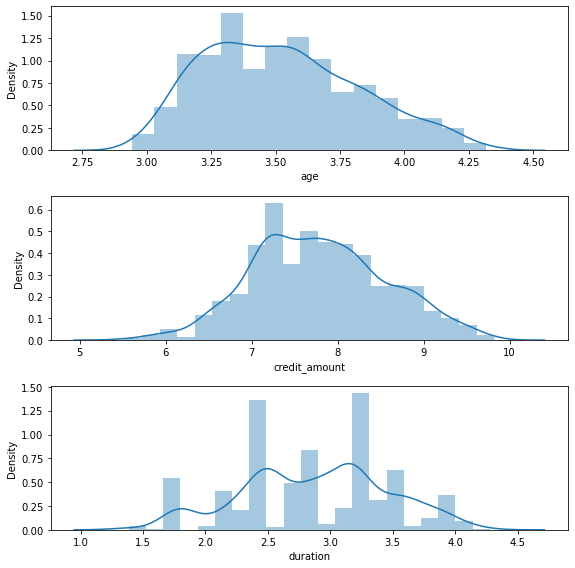

In [96]:
data_f_cluster_log = np.log(data_f_cluster[['age', 'credit_amount','duration']])

fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
sns.distplot(data_f_cluster_log["age"], ax=ax1)
sns.distplot(data_f_cluster_log["credit_amount"], ax=ax2)
sns.distplot(data_f_cluster_log["duration"], ax=ax3)
plt.tight_layout()

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(data_f_cluster_log)

C:\Users\91798\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


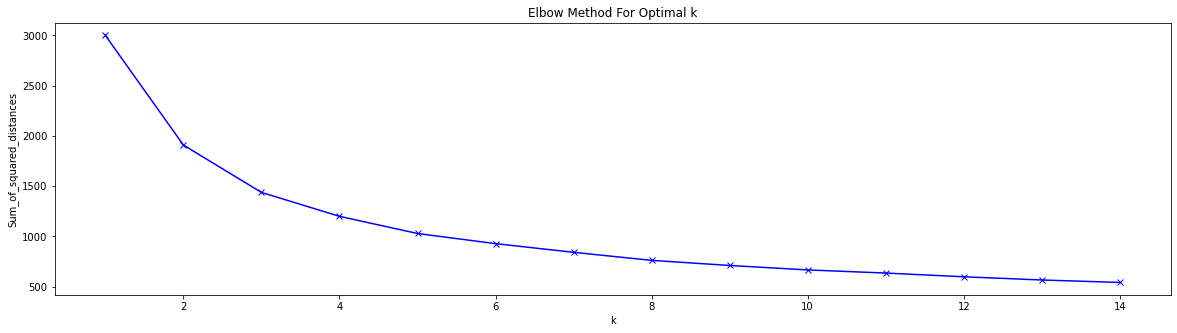

In [98]:
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(cluster_scaled)
    Sum_of_squared_distances.append(km.inertia_)
plt.figure(figsize=(20,5))
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

K-Means


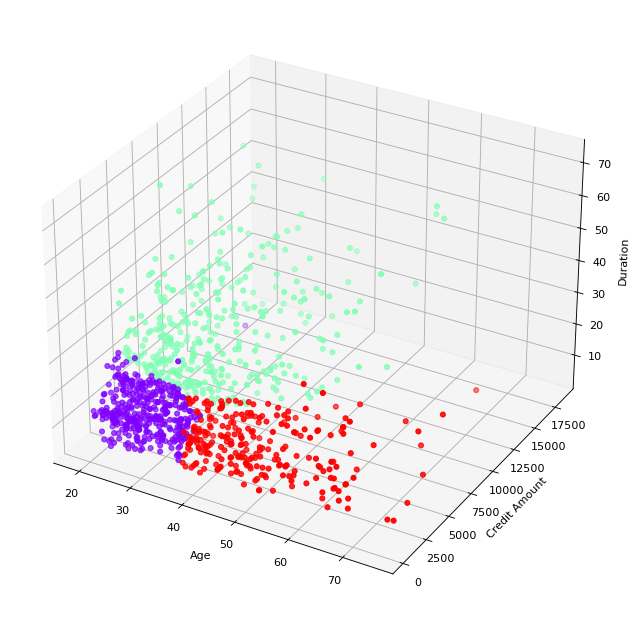

In [99]:
from mpl_toolkits.mplot3d import Axes3D

model = KMeans(n_clusters=3)
model.fit(cluster_scaled)
kmeans_labels = model.labels_

fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(data_f_cluster['age'],data_f_cluster['credit_amount'],data_f_cluster['duration'],c=kmeans_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('Credit Amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)
print("K-Means")

In [100]:
data_f_clustered_kmeans = data_f_cluster.assign(Cluster=kmeans_labels)
grouped_kmeans = data_f_clustered_kmeans.groupby(['Cluster']).mean().round(1)
grouped_kmeans

,credit_amount,age,duration,job
Cluster,,,,
0,1732.2,27.8,14.2,1.8
1,5665.4,34.0,32.2,2.1
2,1979.7,48.7,13.9,1.7


DBSCAN


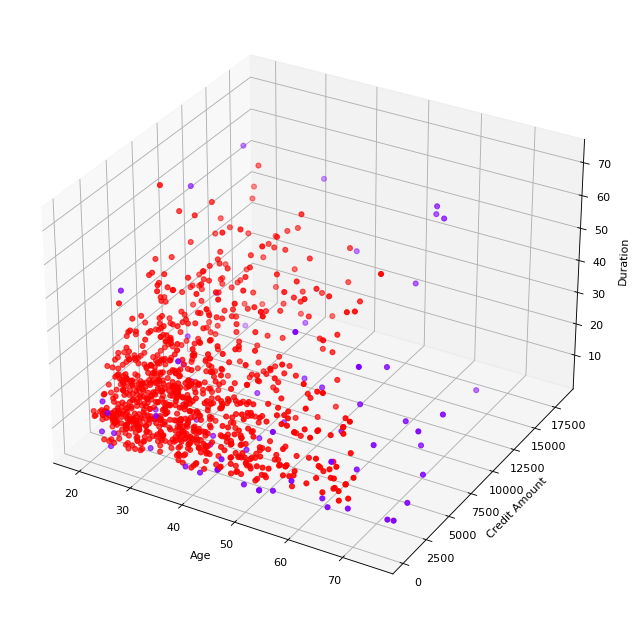

In [101]:
from sklearn.cluster import DBSCAN

model = DBSCAN()
model.fit(cluster_scaled)
dbs_labels = model.labels_

fig = plt.figure(num=None, figsize=(15, 10), dpi=80, facecolor='w', edgecolor='k')
ax = plt.axes(projection="3d")

ax.scatter3D(data_f_cluster['age'],data_f_cluster['credit_amount'],data_f_cluster['duration'],c=dbs_labels, cmap='rainbow')

xLabel = ax.set_xlabel('Age', linespacing=3.2)
yLabel = ax.set_ylabel('Credit Amount', linespacing=3.1)
zLabel = ax.set_zlabel('Duration', linespacing=3.4)
print("DBSCAN")